# Devoir 2 – Question 1(a) : Squelette de Code (Version TA)

Ce notebook fournit **uniquement la structure** nécessaire pour réaliser la partie **1(a)** du devoir :

**→ Sélection aléatoire de 50 firmes du S&P 500 + extraction des prix, EPS et trailing P/E.**

⚠️ **Ce fichier NE contient aucune solution.**  
Toutes les étapes critiques (fusion, calcul du trailing P/E, gestion des dates) sont volontairement remplacées par des `TODO`.

Votre rôle est de compléter les parties manquantes.


**Problème 1a**

In [1]:
# ============================================
# 0. Connexion WRDS
# ============================================

import wrds
import pandas as pd
import numpy as np

db = wrds.Connection()


WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Administrator\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## 1. Charger l'univers S&P 500

Objectif : récupérer les PERMNO des entreprises ayant fait partie du S&P 500 dans la période pertinente.


In [2]:
# ============================================
# 1. Récupération S&P 500
# ============================================

sp500 = db.raw_sql(
    """
    SELECT permno, start, ending
    FROM crsp.msp500list
    WHERE ending >= '2003-01-01'
    """,
    date_cols=['start','ending']
)

sp500.head()


,permno,start,ending
0,10078,1992-08-20,2010-01-28
1,10104,1989-08-03,2024-12-31
2,10107,1994-06-07,2024-12-31
3,10108,2002-07-22,2005-08-11
4,10137,2000-12-11,2011-02-25


## 2. Ajouter les identifiants CRSP (ticker, nom, codes)

Nous utilisons `crsp.msenames` pour enrichir les informations des firmes.


In [3]:
# ============================================
# 2. Ajouter identifiants firmes
# ============================================

msenames = db.raw_sql(
    """
    SELECT permno, comnam, ticker, ncusip,
           namedt, nameendt, shrcd, exchcd, hsiccd
    FROM crsp.msenames
    """,
    date_cols=['namedt','nameendt']
)

msenames["nameendt"] = msenames["nameendt"].fillna(pd.to_datetime("today"))

sp500_full = pd.merge(sp500, msenames, on="permno", how="left")

# Filtre temporel du nom (structure simple, à adapter si nécessaire)
sp500_full = sp500_full[
    (sp500_full["start"] >= sp500_full["namedt"]) &
    (sp500_full["start"] <= sp500_full["nameendt"])
]

sp500_full.head()


,permno,start,ending,comnam,ticker,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd
0,10078,1992-08-20,2010-01-28,SUN MICROSYSTEMS INC,SUNW,86681010,1986-03-04,2004-06-09,11,3,3571
5,10104,1989-08-03,2024-12-31,ORACLE SYSTEMS CORP,ORCL,68389X10,1986-03-12,1995-05-31,11,3,7379
10,10107,1994-06-07,2024-12-31,MICROSOFT CORP,MSFT,59491810,1986-03-13,2004-06-09,11,3,7370
15,10108,2002-07-22,2005-08-11,SUNGARD DATA SYSTEMS INC,SDS,86736310,2002-01-02,2004-06-09,11,1,7374
22,10137,2000-12-11,2011-02-25,ALLEGHENY ENERGY INC,AYE,01736110,1997-10-01,2002-01-01,11,1,4911


## 3. Définir l'univers de firmes et tirer 50 firmes au hasard

On obtient une liste unique de PERMNO, puis on tire 50 firmes aléatoirement.


In [4]:
# ============================================
# 3. Tirage aléatoire de 50 firmes
# ============================================

universe = sp500_full.drop_duplicates(subset="permno")

sample_50 = universe.sample(50, random_state=42)

sample_50[["permno","ticker","comnam","hsiccd"]]


,permno,ticker,comnam,hsiccd
1517,22779,<NA>,MOTOROLA INC,3663
3394,58318,TEX,TEREX CORP NEW,3537
6012,88661,COH,COACH INC,3199
4220,75186,SCH,SCHWAB CHARLES CORP NEW,6211
490,12872,MPC,MARATHON PETROLEUM CORP,2911
2073,27422,CLF,CLIFFS NATURAL RESOURCES INC,1081
6483,91380,RBK,REEBOK INTERNATIONAL LTD,3021
5711,86136,SRE,SEMPRA ENERGY,4932
573,13598,KRFT,KRAFT FOODS GROUP INC,9999
4940,79698,IT,GARTNER INC,8732


## 4. Extraire les prix (daily ou monthly, selon votre choix)

Cette étape récupère les prix CRSP pour les 50 firmes.


In [5]:
# ============================================
# 4. Extraction des prix CRSP
# ============================================

permnos = sample_50["permno"].astype(int).tolist()
permno_str = ",".join(map(str, permnos))

prices = db.raw_sql(
    f"""
    SELECT date, permno, prc, ret, vol, shrout
    FROM crsp.dsf
    WHERE permno IN ({permno_str})
      AND date BETWEEN '2003-01-01' AND '2023-12-31'
    ORDER BY permno, date
    """,
    date_cols=["date"]
)

# Joindre tickers (optionnel)
prices = pd.merge(prices, sample_50[["permno","ticker","comnam"]], on="permno", how="left")

prices.head()
## TODO : # - Corriger PRC négatif # - Gérer NA et valeurs extrêmes
# ============================================
# 4.1 Nettoyage des prix
# ============================================

# 1) Corriger PRC négatif (convention CRSP : signe = côté bid/ask)
prices["prc"] = prices["prc"].abs()

# 2) Retirer les observations sans prix ou sans nombre d’actions
prices = prices.dropna(subset=["prc", "shrout"])

# 3) Filtrer quelques valeurs aberrantes simples sur le prix
#    (seuils arbitraires mais raisonnables pour des actions US)
prices = prices[(prices["prc"] > 0) & (prices["prc"] < 10000)]

prices.head()


,date,permno,prc,ret,vol,shrout,ticker,comnam
0,2003-01-02,11403,11.66,-0.011026,2339600.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
1,2003-01-03,11403,9.24,-0.207547,16931100.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
2,2003-01-06,11403,9.8,0.060606,4575800.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
3,2003-01-07,11403,9.36,-0.044898,2970300.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
4,2003-01-08,11403,9.65,0.030983,1754300.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC


## 5. Récupérer EPS (Compustat)

Vous devez maintenant extraire l'EPS depuis Compustat.
Aucune fusion ni calcul n'est fourni.



In [6]:
# ============================================
# 5. Extraction EPS – À compléter
# ============================================

eps_raw = db.get_table(
    "comp", "funda",
    columns=["gvkey","datadate","epspi","tic"]
)

# TODO :
# - Filtrer période
# - Filtrer sur les firmes de l'échantillon
# - Construire un EPS cohérent avec trailing P/E (ex : TTM)
eps_raw["datadate"] = pd.to_datetime(eps_raw["datadate"])

# -------------------------------
# 1) Filtrer sur la période
#    (cohérente avec les prix : 2003-2023)
# -------------------------------
eps = eps_raw[
    (eps_raw["datadate"] >= "2003-01-01") &
    (eps_raw["datadate"] <= "2023-12-31")
].copy()

# -------------------------------
# 2) Filtrer sur les firmes de l'échantillon
#    -> via le ticker (tic dans Compustat)
# -------------------------------
tickers_sample = sample_50["ticker"].dropna().unique()
eps = eps[eps["tic"].isin(tickers_sample)].copy()

# -------------------------------
# 3) Nettoyage de base
# -------------------------------
eps = eps.rename(columns={"epspi": "eps"})
eps = eps[["gvkey", "tic", "datadate", "eps"]]
eps = eps.dropna(subset=["eps"])
eps = eps.sort_values(["tic", "datadate"])

# -------------------------------
# 4) Construire un EPS cohérent avec un trailing P/E
#    Ici : epspi est un EPS ANNUEL (Compustat funda),
#    on l'interprète comme un EPS "trailing 12 mois" (TTM).
#    On crée donc une colonne eps_ttm qui sera utilisée
#    plus tard pour P/E = Price / eps_ttm.
# -------------------------------
eps["eps_ttm"] = eps["eps"]

eps.head()

,gvkey,tic,datadate,eps,eps_ttm
95621,032930,ADT,2016-12-31,-0.72,-0.72
95622,032930,ADT,2017-12-31,0.46,0.46
95623,032930,ADT,2018-12-31,-0.81,-0.81
95625,032930,ADT,2019-12-31,-0.57,-0.57
95627,032930,ADT,2020-12-31,-0.81,-0.81


## 6. Trailing P/E : squelette

Vous devez fusionner les prix et l'EPS, puis calculer :  

`P/E = Price / EPS`

⚠️ Aucune formule ni fusion finale n'est fournie ici.


In [13]:
# ============================================
# 6. Fusion prix–EPS et construction P/E – À compléter
# ============================================

# Exemple de squelette (à compléter) :

# merged = pd.merge(
#     prices,
#     eps_raw[['tic','datadate','epspi']],   # TODO: remplacer epspi par EPS_TTM si vous le calculez
#     left_on='ticker',
#     right_on='tic',
#     how='left'
# )

# # Conserver EPS antérieur à la date
# merged = merged[merged["datadate"] <= merged["date"]]

# # TODO : Construire trailing P/E
# # merged["pe_trailing"] = merged["prc_abs"] / merged["eps_ttm"]

# merged.head()
# ============================================
# 6. Fusion prix–EPS et construction P/E – À compléter
# ============================================

# 1) Fusion simple par ticker (left_on='ticker', right_on='tic')
merged = pd.merge(
    prices,
    eps[['tic', 'datadate', 'eps_ttm']],   # on utilise EPS_TTM construit dans l'étape 5
    left_on='ticker',
    right_on='tic',
    how='left'
)

# 2) Conserver seulement les observations où l'EPS est antérieur ou égal à la date du prix
merged = merged[merged["datadate"] <= merged["date"]]

# 3) Garder seulement la dernière observation EPS AVANT la date du prix
#    (sinon une firme avec plusieurs EPS par année génère plusieurs lignes par date)
merged = merged.sort_values(["permno", "date", "datadate"])
merged = merged.groupby(["permno", "date"]).tail(1)

# 4) Trailing P/E = price / eps_ttm
merged["pe_trailing"] = merged["prc"] / merged["eps_ttm"]

# ignorer les EPS <= 0
merged.loc[merged["eps_ttm"] <= 0, "pe_trailing"] = np.nan

merged.head()
merged[merged["eps_ttm"] > 0].head()



,date,permno,prc,ret,vol,shrout,ticker,comnam,tic,datadate,eps_ttm,pe_trailing
15091,2004-12-31,11403,13.81,-0.006475,752900.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,51.148148
15121,2005-01-03,11403,13.75,-0.004345,980400.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,50.925926
15151,2005-01-04,11403,13.3,-0.032727,1889500.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.259259
15181,2005-01-05,11403,13.31,0.000752,1926100.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.296296
15211,2005-01-06,11403,13.34,0.002254,1389600.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.407407


**Fin de l'aide et du problème 1A**

**Début problème 1B:**

In [9]:
# ============================================
# 1B. Panneau de base pour les transformations
# ============================================

panel = merged.sort_values(["permno", "date"]).copy()
# --------------------------------------------
# 2) Rendements de l'action
#    - ret_simple : rendement simple CRSP
#    - ret_log    : log-rendement pour analyses éventuelles
# --------------------------------------------

panel["ret_simple"] = panel["ret"]                   # déjà en % décimal dans CRSP
panel["ret_log"]    = np.log1p(panel["ret"])         # log(1+ret)
panel[["permno", "date", "ret", "ret_simple", "ret_log"]].head()


,permno,date,ret,ret_simple,ret_log
7530,11403,2003-12-31,-0.009366,-0.009366,-0.00941
7560,11403,2004-01-02,0.015573,0.015573,0.015453
7590,11403,2004-01-05,0.016977,0.016977,0.016835
7620,11403,2004-01-06,0.001616,0.001616,0.001615
7650,11403,2004-01-07,0.017204,0.017204,0.017058


In [10]:
# --------------------------------------------
# 3) BPA attendu (Expected EPS)
#    Hypothèse : EPS attendu = dernier EPS_TTM connu (LOCF),
#    ce qui est cohérent avec un forecast à court terme.
# --------------------------------------------

panel["eps_expected"] = (
    panel
    .groupby("permno")["eps_ttm"]
    .ffill()              # propage la dernière valeur disponible
)
panel[["permno", "date", "eps_ttm", "eps_expected"]].head(10)


,permno,date,eps_ttm,eps_expected
7530,11403,2003-12-31,-0.07,-0.07
7560,11403,2004-01-02,-0.07,-0.07
7590,11403,2004-01-05,-0.07,-0.07
7620,11403,2004-01-06,-0.07,-0.07
7650,11403,2004-01-07,-0.07,-0.07
7680,11403,2004-01-08,-0.07,-0.07
7710,11403,2004-01-09,-0.07,-0.07
7740,11403,2004-01-12,-0.07,-0.07
7770,11403,2004-01-13,-0.07,-0.07
7800,11403,2004-01-14,-0.07,-0.07


In [11]:
# --------------------------------------------
# 4) Trailing P/E
#    Définition : P/E_t = Price_t / EPS_TTM_t
#    + on enlève les cas où EPS <= 0 (pas interprétable)
# --------------------------------------------

panel["pe_trailing"] = panel["prc"] / panel["eps_ttm"]

# Mettre à NaN si EPS <= 0
panel.loc[panel["eps_ttm"] <= 0, "pe_trailing"] = np.nan

panel[["permno", "date", "prc", "eps_ttm", "pe_trailing"]].head(10)
panel[panel["eps_ttm"] > 0][["permno","date","prc","eps_ttm","pe_trailing"]].head(10)




,permno,date,prc,eps_ttm,pe_trailing
15091,11403,2004-12-31,13.81,0.27,51.148148
15121,11403,2005-01-03,13.75,0.27,50.925926
15151,11403,2005-01-04,13.3,0.27,49.259259
15181,11403,2005-01-05,13.31,0.27,49.296296
15211,11403,2005-01-06,13.34,0.27,49.407407
15241,11403,2005-01-07,13.28,0.27,49.185185
15271,11403,2005-01-10,13.37,0.27,49.518519
15301,11403,2005-01-11,13.57,0.27,50.259259
15331,11403,2005-01-12,13.79,0.27,51.074074
15361,11403,2005-01-13,13.45,0.27,49.814815


**Problème 1b terminé**

**Début Problème 1c**

=== Tableau 1 – Statistiques descriptives globales ===
                      mean     median         std         min           max  \
prc              61.485684  41.850000   71.527937    0.200000    729.919980   
ret_simple        0.000733   0.000545    0.027193   -0.394309      0.685371   
eps_ttm           2.415144   1.870000   12.629155 -182.290000    198.050000   
pe_trailing      64.812119  21.006108  476.752633    0.167634  13183.000000   
composite_ratio  68.678237  46.755000   75.231657    2.610000    729.919980   

                        N  
prc              133728.0  
ret_simple       133721.0  
eps_ttm          133728.0  
pe_trailing      111610.0  
composite_ratio  111610.0  

=== Aperçu des stats par titre (premiers tickers) ===
               prc                                             ret_simple  \
              mean  median         std    min        max count       mean   
ticker                                                                      
AJG      63.9229

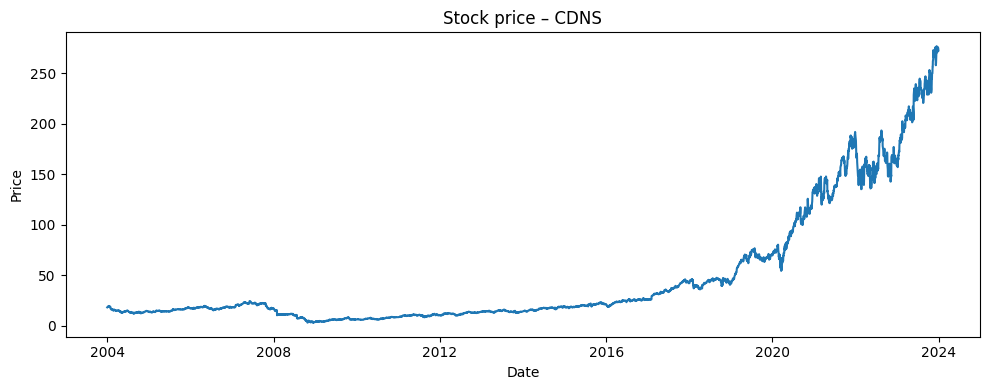

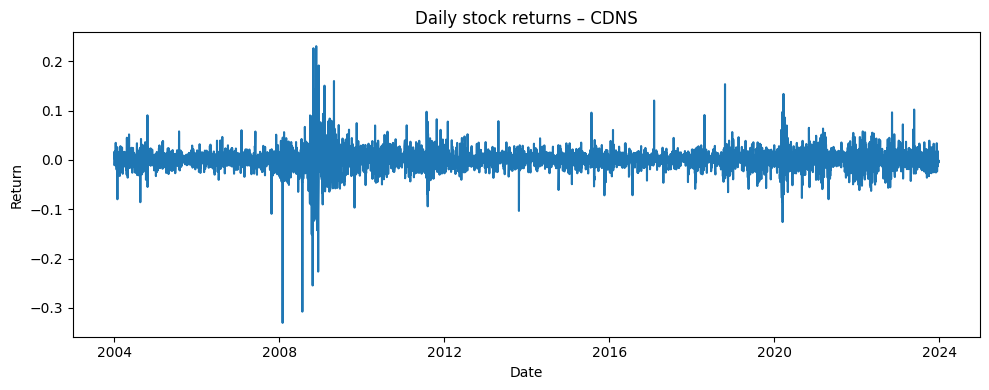

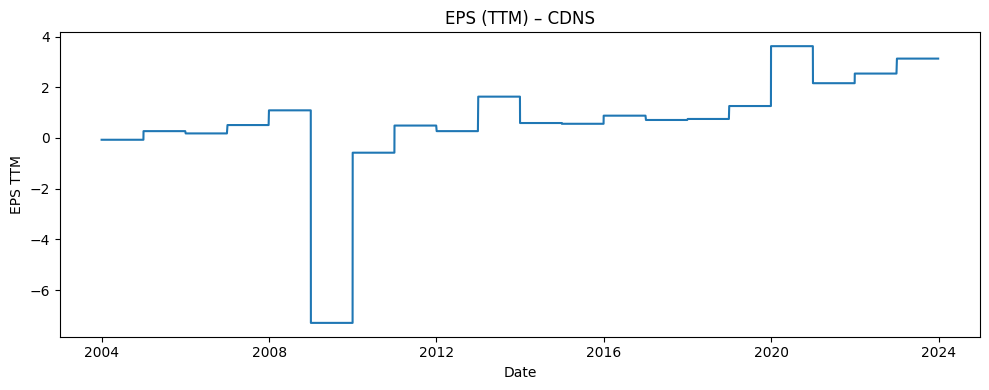

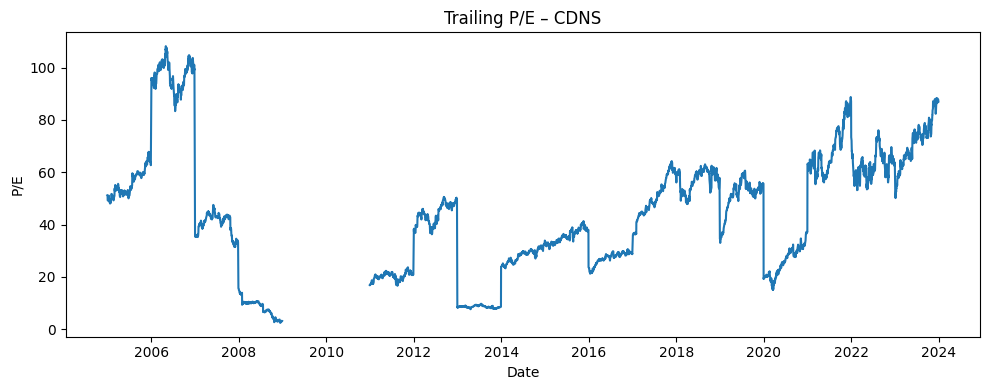

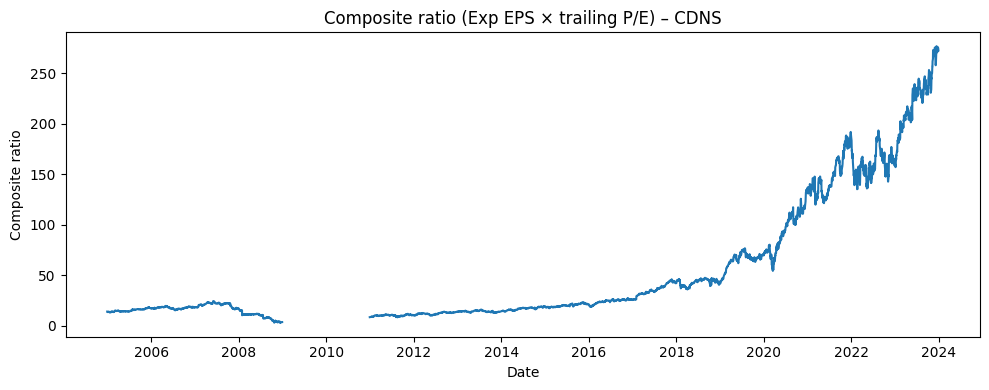

In [12]:

# Problème 1(c) – Tableau descriptif + graphiques


import matplotlib.pyplot as plt

# 1) Composite ratio : Expected EPS × trailing P/E
panel["composite_ratio"] = panel["eps_expected"] * panel["pe_trailing"]

# 2) Tableau de statistiques descriptives globales
vars_1c = ["prc", "ret_simple", "eps_ttm", "pe_trailing", "composite_ratio"]

stats_global = (
    panel[vars_1c]
    .agg(["mean", "median", "std", "min", "max", "count"])
    .T
    .rename(columns={"count": "N"})
)

print("=== Tableau 1 – Statistiques descriptives globales ===")
print(stats_global)

# Un aperçu par titre)
stats_by_ticker = (
    panel
    .groupby("ticker")[vars_1c]
    .agg(["mean", "median", "std", "min", "max", "count"])
)
print("\n=== Aperçu des stats par titre (premiers tickers) ===")
print(stats_by_ticker.head())

# 3) Graphiques de séries temporelles pour une firme représentative,
# J'ai prit le premier ticker dans le panel.
ticker_to_plot = panel["ticker"].dropna().unique()[0]
df_plot = panel[panel["ticker"] == ticker_to_plot].sort_values("date")

print(f"\n=== Graphiques de séries temporelles pour {ticker_to_plot} ===")

series_info = [
    ("Stock price",              "prc",             "Price"),
    ("Daily stock returns",      "ret_simple",      "Return"),
    ("EPS (TTM)",                "eps_ttm",         "EPS TTM"),
    ("Trailing P/E",             "pe_trailing",     "P/E"),
    ("Composite ratio (Exp EPS × trailing P/E)", "composite_ratio", "Composite ratio"),
]

for title_base, col, ylab in series_info:
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot["date"], df_plot[col])
    plt.title(f"{title_base} – {ticker_to_plot}")
    plt.xlabel("Date")
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()
